# 理想高通滤波

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data

In [2]:
def fftfilt(b, x, *n):
    """Filter the signal x with the FIR filter described by the
    coefficients in b using the overlap-add method. If the FFT
    length n is not specified, it and the overlap-add block length
    are selected so as to minimize the computational cost of
    the filtering operation."""

    N_x = len(x)
    N_b = len(b)

    # Determine the FFT length to use:
    if len(n):

        # Use the specified FFT length (rounded up to the nearest
        # power of 2), provided that it is no less than the filter
        # length:
        n = n[0]
        if n != int(n) or n <= 0:
            raise ValueError('n must be a nonnegative integer')
        if n < N_b:
            n = N_b
        N_fft = 2**nextpow2(n)
    else:

        if N_x > N_b:

            # When the filter length is smaller than the signal,
            # choose the FFT length and block size that minimize the
            # FLOPS cost. Since the cost for a length-N FFT is
            # (N/2)*log2(N) and the filtering operation of each block
            # involves 2 FFT operations and N multiplications, the
            # cost of the overlap-add method for 1 length-N block is
            # N*(1+log2(N)). For the sake of efficiency, only FFT
            # lengths that are powers of 2 are considered:
            N = 2**arange(ceil(log2(N_b)), floor(log2(N_x)))
            cost = ceil(N_x/(N-N_b+1))*N*(log2(N)+1)
            N_fft = N[argmin(cost)]

        else:

            # When the filter length is at least as long as the signal,
            # filter the signal using a single block:
            N_fft = 2**nextpow2(N_b+N_x-1)

    N_fft = int(N_fft)

    # Compute the block length:
    L = int(N_fft - N_b + 1)

    # Compute the transform of the filter:
    H = np.fft.fft(b, N_fft)

    #y = np.zeros(N_x,float)
    y = np.zeros(N_x,dtype=H.dtype)
    i = 0
    while i <= N_x:
        il = np.min([i+L,N_x])
        k = np.min([i+N_fft,N_x])
        yt = np.fft.ifft(np.fft.fft(x[i:il],N_fft)*H,N_fft) # Overlap..
        y[i:k] = y[i:k] + yt[:k-i]            # and add
        i += L
    return y

In [21]:
'''
% 频域滤波
% 函数输入：
%       X：输入的空域图像矩阵，double类型
%       H，频域滤波器，一般为图像X的2倍时较好
% 函数输出：
%       Z：输出的空域图像局长呢，数据类型为double类型
 % 二维傅里叶变换
'''
def fftfilt2(X,Z):
    F = np.fft.fft2(X)
    Z = H * F
    Z = np.fft.ifftshift(Z)
    Z = np.abs(np.fft.ifft2(Z))
    return Z

In [23]:
'''
% 理想高通滤波器
% input:
%     M,N:频域滤波器的尺寸
%     D0：带阻滤波器的截止频率
% output:
%       H：M x N的矩阵，表示频域滤波器矩阵，数据类型为double，
'''
def freqfilter_ideal_Hp(M,N,D0):
    u = np.arange(-M//2,M//2)
    v = np.arange(-N//2,N//2)
    [U,V] = np.meshgrid(u,v)
    D = np.sqrt(U ** 2 + V **2)
    H = np.zeros_like(D)
    idx = (D > D0)
    H[idx] = D[idx]
    return H,U,V

In [4]:
def noise_gaussian(M,N,a = 0,b=1):
    R = a + b * np.random.randn(M,N)
    return R

In [5]:
def nextpow2(x):
    dst = 0.0
    eps = 1.0e-5
    if x == 0:
        return dst
    else:
        dst = np.ceil(np.log2(x + eps))
    return dst
    

In [6]:
'''
图像理想高通滤波
'''
def freqfilter_ideal_hp(src,D0):
    src_f = src.astype('float64') / 255.0
    # 傅立叶变换 
    img_fft = np.fft.fft2(src_f)
    img_fftshift = np.fft.fftshift(img_fft)
    
    # 进行理想低通滤波
    idx = (np.abs(img_fftshift) >= D0)
#     print(np.abs(img_fftshift))
    dst_fftshift = np.zeros_like(img_fftshift)
    dst_fftshift[idx] = img_fftshift[idx]
#     dst_fftshift[~idx] = 0

    dst_ifftshift = np.fft.ifftshift(dst_fftshift)
    dst = np.fft.ifft2(dst_ifftshift)
    dst = np.abs(dst)
    dst = dst * 255
    dst[dst < 0] = 0
    dst[dst > 255] = 255
    
    return dst.astype('uint8')

In [7]:
src = cv2.cvtColor(cv2.imread('../../datas/f3.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [17]:
rows,cols = gray.shape
noise = noise_gaussian(rows,cols,a=0,b=0.1)
src_noise_gray = gray.astype(np.float32) + noise * 255

src_noise = np.zeros(src.shape,dtype=np.float64)
src_noise[:,:,0] = np.float64(src[:,:,0]) + noise * 255
src_noise[:,:,1] = np.float64(src[:,:,1]) + noise * 255
src_noise[:,:,2] = np.float64(src[:,:,2]) + noise * 255

src_noise[src_noise < 0] = 0
src_noise[src_noise > 255] = 255
src_noise = src_noise.astype(np.uint8)
# src_noise = src_noise / 255.0

In [9]:
# D0 = 64 / 255.0
# hp = freqfilter_ideal_Hp(rows,cols,D0)

In [18]:
dstgray = freqfilter_ideal_hp(src_noise_gray.astype('uint8'),64)
dstr = freqfilter_ideal_hp(src_noise[:,:,0],70)
dstg = freqfilter_ideal_hp(src_noise[:,:,1],70)
dstb = freqfilter_ideal_hp(src_noise[:,:,2],70)

In [11]:
# dst = fftfilt(src_noise.reshape(rows * cols,),hp.reshape((rows * cols,)))

In [12]:
# dst = np.abs(np.real(dst)).reshape((rows,cols))

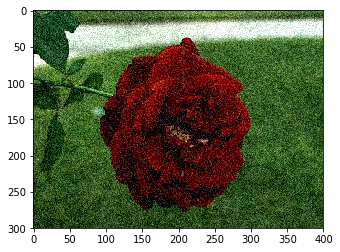

In [19]:
plt.imshow(src_noise)

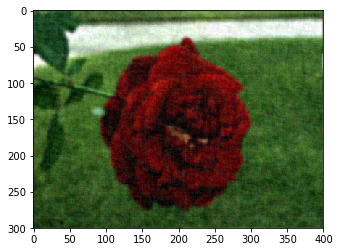

In [20]:
plt.imshow(cv2.merge([dstr,dstg,dstb]))

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

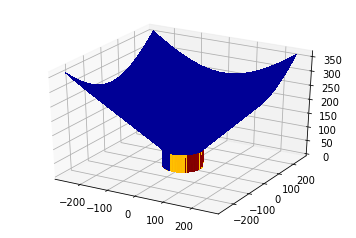

In [28]:
fig = plt.figure()
ax = fig.gca(projection='3d')
H,U,V = freqfilter_ideal_Hp(512,512,64)
Gx, Gy = np.gradient(H)
G = (Gx**2+Gy**2)**.5
N = G/G.max()
ax.plot_surface(
    U, V, H, rstride=1, cstride=1,
    facecolors=cm.jet(N),
    linewidth=0, antialiased=False, shade=False)
# plt.show()

参考：

[1]. https://stackoverflow.com/questions/34722985/matlab-fftfilt-equivalent-for-python